<a href="https://colab.research.google.com/github/carp-x/ML_Colab/blob/main/mnist/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# environment

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [ ]:
# cuda or not

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
# input class

class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image label
        label = torch.as_tensor(self.data_df.iloc[index,0])

        # image data, normalised from 0-255 to 0-1
        image_values = torch.as_tensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor
        return label, image_values

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [ ]:
# mount drive

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
# input import

mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/mnist/mnist_train.csv')

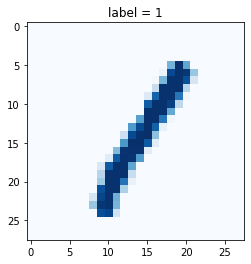

In [ ]:
# input check

mnist_dataset.plot_image(23)

In [ ]:
# classifier class

class Classifier(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, 10)
        )

        # create loss function
        self.loss_function = nn.CrossEntropyLoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(xlim=(0, 25000), ylim=(0, 30), figsize=(16, 8), alpha=0.1, marker='.', grid=True, xticks=range(0, 30000, 5000), yticks=range(0, 35, 5))
        pass

    pass

In [ ]:
%%time
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor in mnist_dataset:
        C.train(image_data_tensor, label)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
CPU times: user 6min 51s, sys: 11 s, total: 7min 2s
Wall time: 7min 9s


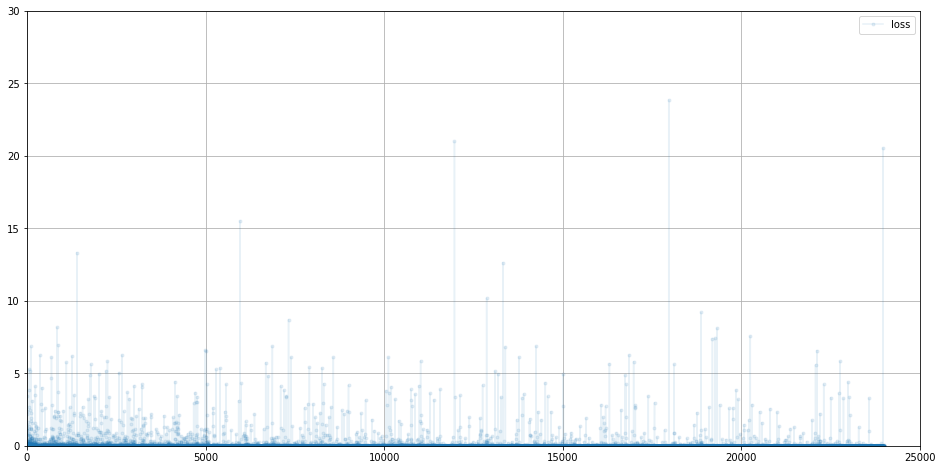

In [ ]:
# plot classifier error

C.plot_progress()

In [ ]:
# load MNIST test data

mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/mnist/mnist_test.csv')

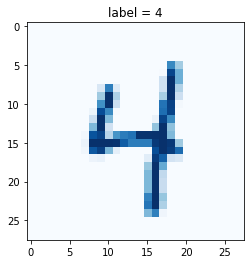

In [ ]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

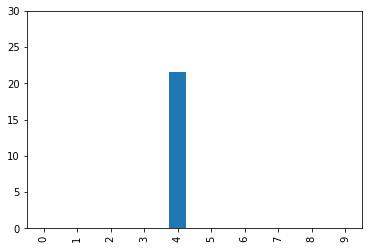

In [ ]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,30))

In [ ]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().cpu().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1

    pass

print(score, items, score/items)

9709 10000 0.9709
